In [ ]:
!wandb disabled


W&B disabled.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, ClassLabel, load_metric
import numpy as np
import torch

In [ ]:
# Load the tokenizer and model
model_name = "google/bigbird-roberta-base"
tokenizer = BigBirdTokenizer.from_pretrained(model_name)
model = BigBirdForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load dataset
import pandas as pd
from datasets import Dataset

# Load the JSON file into a pandas DataFrame
df = pd.read_json("uoa-20-trainset-cleaned.json", lines=True)

# Convert the pandas DataFrame to a datasets Dataset
dataset = Dataset.from_pandas(df)

In [ ]:
# Label adjustment: convert 2, 3, 4 to 0, 1, 2 for model
def preprocess_labels(example):
    example["label"] = int(example["label"]) - 2
    return example

dataset = dataset.map(preprocess_labels)

Map:   0%|          | 0/959 [00:00<?, ? examples/s]

In [ ]:
# Tokenization
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=4096,
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/959 [00:00<?, ? examples/s]

In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./bigbird-ref",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=5,
    save_steps=10,
    save_total_limit=2,
    report_to="none",              # ensures output is shown in notebook
    disable_tqdm=False,            # enables tqdm logging bar
    logging_strategy="steps",      # explicitly logs by steps
)

In [ ]:
# Split dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
tokenized_dataset = train_test_split

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)

# Train
trainer.train()

/tmp/ipython-input-11-3978380983.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
5,0.851300
10,0.786400
15,0.661600
20,0.668400
25,1.224100
30,0.826400
35,0.736300
40,0.726100
45,0.550900
50,0.565300


TrainOutput(global_step=576, training_loss=0.7970331544573936, metrics={'train_runtime': 4962.7675, 'train_samples_per_second': 0.464, 'train_steps_per_second': 0.116, 'total_flos': 4876789402607616.0, 'train_loss': 0.7970331544573936, 'epoch': 3.0})

In [ ]:
# Save model
trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

# Print final training logs
for log in trainer.state.log_history:
    print(log)


{'loss': 0.8513, 'grad_norm': 6.504049777984619, 'learning_rate': 4.965277777777778e-05, 'epoch': 0.02607561929595828, 'step': 5}
{'loss': 0.7864, 'grad_norm': 8.838371276855469, 'learning_rate': 4.921875e-05, 'epoch': 0.05215123859191656, 'step': 10}
{'loss': 0.6616, 'grad_norm': 5.314701557159424, 'learning_rate': 4.8784722222222225e-05, 'epoch': 0.07822685788787484, 'step': 15}
{'loss': 0.6684, 'grad_norm': 3.530820608139038, 'learning_rate': 4.835069444444444e-05, 'epoch': 0.10430247718383312, 'step': 20}
{'loss': 1.2241, 'grad_norm': 2.466148853302002, 'learning_rate': 4.791666666666667e-05, 'epoch': 0.1303780964797914, 'step': 25}
{'loss': 0.8264, 'grad_norm': 2.715113878250122, 'learning_rate': 4.748263888888889e-05, 'epoch': 0.15645371577574968, 'step': 30}
{'loss': 0.7363, 'grad_norm': 6.677099227905273, 'learning_rate': 4.704861111111111e-05, 'epoch': 0.18252933507170796, 'step': 35}
{'loss': 0.7261, 'grad_norm': 10.155241012573242, 'learning_rate': 4.6614583333333336e-05, 'e

**INFERENCE**

In [ ]:
%pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.3 MB/s eta 0:00:00


Extracted: ['pdfs/', 'pdfs/10.1002_berj.3323.pdf', 'pdfs/10.1002_car.2392.pdf', 'pdfs/10.1002_casp.2297.pdf', 'pdfs/10.1002_hec.3630.pdf', 'pdfs/10.1002_icd.2047.pdf', 'pdfs/10.1002_jip.1514.pdf', 'pdfs/10.1002_nvsm.1576.pdf', 'pdfs/10.1007_978-1-137-35131-9.pdf', 'pdfs/10.1007_978-3-030-26342-3_28.pdf', 'pdfs/10.1007_978-3-030-41437-5.pdf', 'pdfs/10.1007_978-3-030-49825-2_5.pdf', 'pdfs/10.1007_978-3-319-74078-2_43-1.pdf', 'pdfs/10.1007_s00127-015-1084-4.pdf', 'pdfs/10.1007_s10198-016-0816-z.pdf', 'pdfs/10.1007_s10433-016-0405-0.pdf', 'pdfs/10.1007_s10610-019-09414-6.pdf', 'pdfs/10.1007_s10612-018-9426-7.pdf', 'pdfs/10.1007_s10640-020-00444-x.pdf', 'pdfs/10.1007_s10680-017-9420-x.pdf', 'pdfs/10.1007_s10680-020-09563-z.pdf', 'pdfs/10.1007_s10826-019-01398-5.pdf', 'pdfs/10.1007_s10888-017-9350-1.pdf', 'pdfs/10.1007_s10888-017-9365-7.pdf', 'pdfs/10.1007_s11199-018-0949-x.pdf', 'pdfs/10.1007_s11469-017-9848-6.pdf', 'pdfs/10.1007_s12144-019-00567-5.pdf', 'pdfs/10.1007_s12671-020-01395-6.pdf

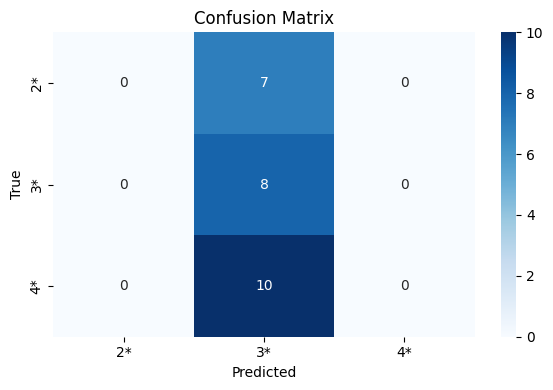

Error reading ./pdfs_unzipped/pdfs/10.1002_car.2392.pdf: EOF marker not found
Error reading ./pdfs_unzipped/pdfs/10.1016_B978-0-08-100750-1.00007-3.pdf: EOF marker not found
Error reading ./pdfs_unzipped/pdfs/10.1007_s10610-019-09414-6.pdf: EOF marker not found
Error reading ./pdfs_unzipped/pdfs/10.1007_s11199-018-0949-x.pdf: EOF marker not found
Error reading ./pdfs_unzipped/pdfs/10.1007_978-3-030-41437-5.pdf: EOF marker not found

✅ Saved predictions to 'ref_predictions.csv'


In [ ]:
import os
import zipfile
import glob
import pandas as pd
import torch
import PyPDF2
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Paths ----
zip_path = "./pdfs.zip"
extract_dir = "./pdfs_unzipped"
csv_path = "uoa-20-ots.csv"
model_name = "./final_model"

# ---- Unzip PDFs ----
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print("Extracted:", zip_ref.namelist())

# ---- Load model and tokenizer ----
tokenizer = BigBirdTokenizer.from_pretrained(model_name)
model = BigBirdForSequenceClassification.from_pretrained(model_name)
model.eval()

# ---- Extract text from PDF ----
def extract_text_from_pdf(pdf_file):
    try:
        with open(pdf_file, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            text = ""
            for page in reader.pages:
                text += page.extract_text() or ""
        return text
    except Exception as e:
        print(f"Error reading {pdf_file}: {e}")
        return None

# ---- Predict score ----
def predict_pdf(pdf_file):
    text = extract_text_from_pdf(pdf_file)
    if text is None or not text.strip():
        return "No text"

    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=4096,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

    return {0: "2*", 1: "3*", 2: "4*"}.get(predicted_class, "Unknown")

# ---- Load ground truth ----
df = pd.read_csv(csv_path)
ground_truth = dict(zip(df["PDF_File"], df["Assigned_Label"]))

# ---- Predict and Compare ----
pdf_files = glob.glob(os.path.join(extract_dir, "**", "*.pdf"), recursive=True)
print(f"Found {len(pdf_files)} PDF files.\n")

y_true = []
y_pred = []

for full_path in pdf_files:
    filename = os.path.basename(full_path)
    true_label = ground_truth.get(filename)

    if not true_label:
        print(f"⚠️ Skipping {filename}: No REF score found in CSV.")
        continue

    predicted_label = predict_pdf(full_path)

    if predicted_label == "No text":
        print(f"⚠️ Skipping {filename}: Could not extract text.")
        continue

    print(f"{filename}: True = {true_label}, Predicted = {predicted_label}")

    y_true.append(true_label)
    y_pred.append(predicted_label)

# ---- Evaluation ----
print("\n--- Evaluation Metrics ---")
label_order = ["2*", "3*", "4*"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, labels=label_order))
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=label_order)
print(cm)

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---- Save predictions to CSV ----
results_df = pd.DataFrame({
    "PDF_File": [os.path.basename(p) for p in pdf_files if os.path.basename(p) in ground_truth and extract_text_from_pdf(p) is not None and extract_text_from_pdf(p).strip()],
    "True_Label": y_true,
    "Predicted_Label": y_pred
})
results_df.to_csv("ref_predictions.csv", index=False)
print("\n✅ Saved predictions to 'ref_predictions.csv'")